# Homework Assignment  5

In [0]:
!pip install turicreate

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [0]:
# Change settings here
DATASET = 'bitcoin'
FILENAME = 'bitcoin.tar.gz'
DOWNLOAD = f'http://dynamics.cs.washington.edu/nobackup/{DATASET}/{FILENAME}'

In [0]:
# clean main folders
!rm -r *
!ls

# Creating a dataset directory. 
# -p Will also create any intermediate directories that don't exist
!mkdir -p ./datasets/$DATASET/zip
!mkdir -p ./datasets/$DATASET/data
!ls ./datasets/$DATASET

# # download the dataset from SSA and unzip it
!wget $DOWNLOAD -O ./datasets/$DATASET/zip/$FILENAME
!ls ./datasets/$DATASET/zip
# ZIP
# !unzip {"./datasets/$DATASET/zip/$FILENAME"} -d {"./datasets/$DATASET/zip/"}
# tar.gz
!tar -xf ./datasets/$DATASET/zip/$FILENAME -C ./datasets/$DATASET/data
!rm -r ./datasets/$DATASET/zip/
# !tar -z -x -v -f "./datasets/$DATASET/zip/$FILENAME"

data  zip
--2020-05-11 21:16:55--  http://dynamics.cs.washington.edu/nobackup/bitcoin/bitcoin.tar.gz
Resolving dynamics.cs.washington.edu (dynamics.cs.washington.edu)... 128.208.3.120, 2607:4000:200:12::78
Connecting to dynamics.cs.washington.edu (dynamics.cs.washington.edu)|128.208.3.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 678858686 (647M) [application/x-gzip]
Saving to: ‘./datasets/bitcoin/zip/bitcoin.tar.gz’

./datasets/bitcoin/ 100%[===================>] 647.41M  1.97MB/s    in 5m 41s  

2020-05-11 21:22:36 (1.90 MB/s) - ‘./datasets/bitcoin/zip/bitcoin.tar.gz’ saved [678858686/678858686]

bitcoin.tar.gz


In [0]:
!ls ./datasets/$DATASET/data/$DATASET

bitcoin.links.csv     bitcoin.vertices.csv
bitcoin.links.sframe  bitcoin.vertices.sframe


**Select a directed network, and develop a simple link prediction classifier based on the network's directed topology (40pt).**

In [0]:
import turicreate as tc
FOLDER = 'bitcoin'
FILE_PATH = f'./datasets/{DATASET}/data/{FOLDER}'
print(FILE_PATH)

bc_sf = tc.SGraph(vertices=tc.load_sframe(f'{FILE_PATH}/bitcoin.vertices.sframe'),
                     edges=tc.load_sframe(f'{FILE_PATH}/bitcoin.links.sframe')[:10000],
                     vid_field="vid",
                     src_field="src_id",
                     dst_field="dst_id")
bc_sf

./datasets/bitcoin/data/bitcoin


SGraph({'num_edges': 10000, 'num_vertices': 6336769})
Vertex Fields:['__id', 'first_transaction_date']
Edge Fields:['__src_id', '__dst_id', 'count', 'maxdate', 'mindate']

In [0]:
import networkx as nx

def sgraph2nxgraph(sgraph, is_directed=True, add_vertices_attributes=True, add_edges_attributes=True):
    if is_directed:
        nx_g = nx.DiGraph()
    else:
        nx_g = nx.Graph()
    if add_vertices_attributes:
        vertices = [(r['__id'] , r) for r in sgraph.vertices]
    else:
        vertices = list(sgraph.get_vertices()['__id'])

    if add_edges_attributes:
        edges = [(r['__src_id'], r['__dst_id'], r) for r in sgraph.edges]
    else:
        edges = [(e['__src_id'], e['__dst_id']) for e in sgraph.get_edges()]
    nx_g.add_nodes_from(vertices)
    nx_g.add_edges_from(edges)
    return nx_g

g = sgraph2nxgraph(bc_sf,
                      is_directed=True,
                      add_vertices_attributes=True,
                      add_edges_attributes=True)
g

In [0]:
# This is for predicting missing links scenario
import random 

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)
            
    
postive_links = select_random_existing_links(g,10000)
negative_links = select_random_non_existing_links(g,10000)
postive_links

[('2959050', '25'),
 ('4100410', '1026368'),
 ('5391209', '5391210'),
 ('3905667', '12061'),
 ('2098867', '164104'),
 ('489726', '5678412'),
 ('1226601', '846991'),
 ('5949366', '5949367'),
 ('1121799', '842514'),
 ('5914377', '25'),
 ('6162192', '109994'),
 ('2572973', '6290784'),
 ('6106920', '133212'),
 ('5431823', '5431833'),
 ('5495567', '477256'),
 ('6077019', '6357'),
 ('6095195', '11'),
 ('1819521', '512'),
 ('4265629', '2513873'),
 ('2722005', '2722006'),
 ('3190555', '1207145'),
 ('171272', '171273'),
 ('5507367', '6679'),
 ('2806687', '366'),
 ('5546003', '1355510'),
 ('2759838', '569283'),
 ('1047460', '1572799'),
 ('3414294', '5954'),
 ('692569', '471497'),
 ('3946984', '334595'),
 ('97650', '442283'),
 ('4213295', '11'),
 ('4277944', '1905'),
 ('6239769', '6239770'),
 ('2427523', '2427524'),
 ('2922377', '29'),
 ('4816955', '366948'),
 ('1483557', '12564'),
 ('545246', '4526683'),
 ('763948', '763944'),
 ('163938', '25'),
 ('5334482', '5334470'),
 ('3960779', '3959641'),


In [0]:
!pip install tqdm

In [0]:
from tqdm import tqdm_notebook as tqdm 

def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v))
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(g, u,v)
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


{'class': True,
 'common_friends': 0,
 'degree_u': 0,
 'degree_v': 0,
 'total_friends': 0}

In [0]:
import turicreate as tc
features_list = [
                 'degree_v',
                 'degree_u',
                 'total_friends',
                 'common_friends',
                 'class'
                 ]
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,total_friends
1,0,0,0,0
1,0,3,0,3
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,1,0,1
1,0,0,0,0


In [0]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = [
                 'degree_v',
                 'degree_u',
                 'total_friends',
                 'common_friends'
                 ]
cls = tc.classifier.create(train,features=features_list, target="class")
cls

Train size 15929
Test size: 4071
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 15132

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.008959     | 0.607322          | 0.613551            | 0.662952          | 0.660853            |

| 2         | 0.021739     | 0.607322          | 0.613551            | 0.646502          | 0.643083            |

| 3         | 0.030281     | 0.607322          | 0.613551            | 0.636425          | 0.632183            |

| 4         | 0.038727     | 0.607322          | 0.613551            | 0.629885          | 0.625100            |

| 5         | 0.048740     | 0.607322          | 0.613551            | 0.625487          | 0.620338            |

| 10        | 0.086296     | 0.607322          | 0.613551            | 0.616999          | 0.611217            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 15132

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.008932     | 0.607322          | 0.613551            | 0.627379          | 0.622557            |

| 2         | 0.016498     | 0.607322          | 0.613551            | 0.627309          | 0.622484            |

| 3         | 0.024809     | 0.607322          | 0.613551            | 0.627285          | 0.622468            |

| 4         | 0.033202     | 0.607322          | 0.613551            | 0.627265          | 0.622438            |

| 5         | 0.040320     | 0.607322          | 0.613551            | 0.627246          | 0.622418            |

| 10        | 0.075589     | 0.607322          | 0.613551            | 0.627268          | 0.622442            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 15132

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.009158     | 0.607322          | 0.613551            | 0.627249          | 0.622407            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 15132

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients    : 5

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.014068     | 0.500397          | 0.501882            |

| 1         | 6        | 21.000000 | 0.040359     | 0.558485          | 0.569636            |

| 2         | 15       | 0.012162  | 0.066075     | 0.558485          | 0.569636            |

| 3         | 16       | 0.015202  | 0.072096     | 0.558485          | 0.569636            |

| 4         | 21       | 1.292192  | 0.089685     | 0.558485          | 0.569636            |

| 9         | 29       | 1.243709  | 0.127378     | 0.585977          | 0.594730            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 15132

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients      : 5

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.019514     | 0.566416          | 0.579674            |

| 2         | 3        | 0.033792     | 0.569323          | 0.580928            |

| 3         | 4        | 0.044896     | 0.573024          | 0.585947            |

| 4         | 5        | 0.057989     | 0.579038          | 0.590966            |

| 5         | 6        | 0.070229     | 0.587827          | 0.599749            |

| 10        | 11       | 0.125519     | 0.607322          | 0.613551            |

+-----------+----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.6135508155583438
PROGRESS: RandomForestClassifier          : 0.6135508155583438
PROGRESS: DecisionTreeClassifier          : 0.6135508155583438
PROGRESS: SVMClassifier                   : 0.5947302383939774
PROGRESS: LogisticClassifier              : 0.6135508155583438
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 15132
Number of feature columns      : 4
Number of unpacked features    : 4
Number of classes              : 2

Settings
--------
Number of trees                : 10
Max tree depth                 : 6
Training time (sec)            : 0.0867
Training accuracy              : 0.6073
Validation accuracy            : 0.6136
Training log_loss              : 0.617
Validation log_loss            : 0.6112
Training auc                   : 0.6078
Validation auc                 : 0.6152

In [0]:
results = cls.evaluate(test)
results

{'accuracy': 0.5951854581183984,
 'auc': 0.5940732100084861,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  389  |
 |      1       |        0        |  1639 |
 |      0       |        0        |  2034 |
 |      0       |        1        |   9   |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.32069249793899424,
 'log_loss': 0.6289505464831612,
 'precision': 0.9773869346733668,
 'recall': 0.19181459566074952,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2028 | 2043 |
 |   1e-05   | 1.0 | 1.0 | 2028 | 2043 |
 |   2e-05   | 1.

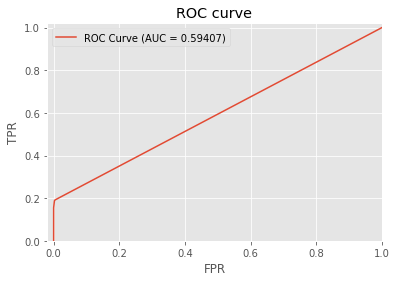

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

In [0]:
cls.classify(test)

class,probability
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506
0,0.5583647191524506


**Use node or link embedding features and try to improve the classification (20pt)**

In [0]:
!pip install karateclub

     |████████████████████████████████| 1.8MB 5.7MB/s 
  Created wheel for karateclub: filename=karateclub-1.0.2-cp36-none-any.whl size=63926 sha256=82bb6844beba209b71f7dc63263a5933c40dea191f6b840f8d63cf24372d68b0
  Stored in directory: /root/.cache/pip/wheels/04/38/17/d651612a0cfca1cab6e6a173b80b5ca3eba51accd05d355305
Successfully built karateclub


**Convert to undirected**

In [0]:
ug = g.to_undirected() # Creating Undirected Graph
print(nx.info(ug))

Name: 
Type: Graph
Number of nodes: 6336769
Number of edges: 10000
Average degree:   0.0032


**Let's convert the network from nodes represented by string to network with nodes represented by numbers:**

In [0]:
?zip

In [0]:
l =  zip(ug.nodes(), range(len(ug.nodes())))
l = list(l)
l[:10]

[('5947163', 0),
 ('5854553', 1),
 ('232635', 2),
 ('3746728', 3),
 ('2481512', 4),
 ('997042', 5),
 ('4484990', 6),
 ('4680065', 7),
 ('3235776', 8),
 ('4764442', 9)]

In [0]:
nodes_dict = dict(l)
r_node_dict = {v:k for k,v in nodes_dict.items()}
list(r_node_dict.items())[:10]

[(0, '5947163'),
 (1, '5854553'),
 (2, '232635'),
 (3, '3746728'),
 (4, '2481512'),
 (5, '997042'),
 (6, '4484990'),
 (7, '4680065'),
 (8, '3235776'),
 (9, '4764442')]

Name: 
Type: Graph
Number of nodes: 6336769
Number of edges: 10000
Average degree:   0.0032
Name: 
Type: Graph
Number of nodes: 16802
Number of edges: 10000
Average degree:   1.1903


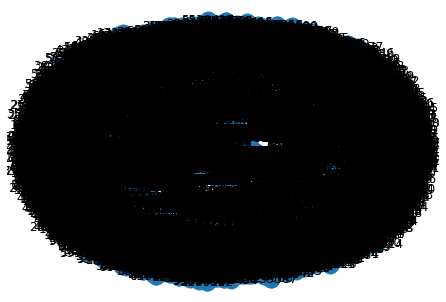

In [0]:
h = nx.Graph()
for e1,e2 in ug.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])
print(nx.info(ug))
print(nx.info(h))
nx.draw(h, with_labels=True)

**As suggested by Michel, we can find the largest connected component**

Name: 
Type: Graph
Number of nodes: 16802
Number of edges: 10000
Average degree:   1.1903
Name: 
Type: Graph
Number of nodes: 687
Number of edges: 686
Average degree:   1.9971


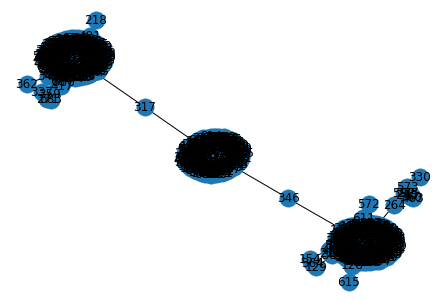

In [0]:
largest_cc = max(nx.connected_components(h), key=len)
h_lcc = nx.Graph()
l_cc =  zip(list(largest_cc), range(len(largest_cc)))
l_cc = list(l_cc)
nodes_dict_cc = dict(l_cc)
r_node_dict_cc = {v:k for k,v in nodes_dict_cc.items()}
for e1,e2 in h.edges():
  if e1 in largest_cc and e2 in largest_cc:
    h_lcc.add_edge(nodes_dict_cc[e1], nodes_dict_cc[e2])
print(nx.info(h))
print(nx.info(h_lcc))
nx.draw(h_lcc, with_labels=True)

In [0]:
import karateclub

model = karateclub.DeepWalk()
model.fit(h_lcc)
embedding = model.get_embedding()
embedding

array([[-0.3670844 , -0.09041262, -0.40071565, ..., -0.06806529,
        -0.40223503,  0.04568953],
       [-0.20605291,  0.05926587, -0.19459963, ..., -0.09509101,
        -0.4837867 ,  0.14387393],
       [ 0.15607516,  0.33135724,  0.15902478, ...,  0.1913189 ,
        -0.7365505 , -0.21583083],
       ...,
       [ 0.00254531, -0.02880417,  0.19493987, ..., -0.06962178,
         0.3804029 , -0.16770962],
       [ 0.1589403 ,  0.24838856,  0.11800299, ...,  0.1756552 ,
        -0.6547078 , -0.19937526],
       [-0.4773666 , -0.17510511, -0.3673856 , ..., -0.23826239,
        -0.32496434,  0.12108441]], dtype=float32)

In [0]:
postive_links_cc = select_random_existing_links(h_lcc,10000)
negative_links_cc = select_random_non_existing_links(h_lcc,10000)
postive_links_cc

[(158, 588),
 (158, 132),
 (158, 277),
 (257, 187),
 (651, 397),
 (651, 612),
 (651, 343),
 (651, 674),
 (158, 585),
 (651, 225),
 (257, 144),
 (158, 524),
 (651, 71),
 (257, 344),
 (158, 72),
 (257, 102),
 (158, 507),
 (651, 349),
 (651, 291),
 (158, 494),
 (257, 428),
 (158, 481),
 (158, 358),
 (158, 179),
 (257, 163),
 (257, 368),
 (257, 363),
 (257, 197),
 (651, 351),
 (158, 361),
 (158, 329),
 (158, 480),
 (651, 241),
 (158, 579),
 (651, 437),
 (651, 415),
 (257, 115),
 (158, 43),
 (158, 204),
 (257, 548),
 (257, 8),
 (158, 231),
 (651, 51),
 (264, 463),
 (257, 106),
 (257, 348),
 (257, 278),
 (158, 254),
 (257, 55),
 (257, 62),
 (257, 543),
 (158, 380),
 (651, 434),
 (158, 408),
 (257, 136),
 (158, 421),
 (158, 248),
 (340, 362),
 (257, 208),
 (158, 138),
 (158, 121),
 (257, 479),
 (257, 320),
 (158, 65),
 (651, 373),
 (257, 379),
 (158, 514),
 (158, 0),
 (158, 587),
 (651, 609),
 (257, 170),
 (158, 456),
 (651, 459),
 (573, 330),
 (651, 529),
 (651, 474),
 (651, 433),
 (257, 165

In [0]:
links_features = []

for i in tqdm(range(len(postive_links_cc))):    
    u,v = postive_links_cc[i]
    d = get_features_dict(h_lcc, u, v)
    if d is None:
        continue
    d['class'] = True
    for j in range(len(embedding[0])):
        d[f'e_{j}'] = embedding[u][j] + embedding[v][j]
    links_features.append(d)

for i in tqdm(range(len(negative_links_cc))):    
    u,v = negative_links_cc[i]
    d = get_features_dict(h_lcc, u,v )
    if d is None:
        continue
    d['class'] = False
    for j in range(len(embedding[0])):
        d[f'e_{j}'] = embedding[u][j] + embedding[v][j]
    links_features.append(d)

links_features[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


{'class': True,
 'common_friends': 0,
 'degree_u': 239,
 'degree_v': 0,
 'e_0': -1.0215495,
 'e_1': -0.52664524,
 'e_10': 1.5904187,
 'e_100': -0.16118595,
 'e_101': -0.63446784,
 'e_102': -1.2456136,
 'e_103': -0.39994296,
 'e_104': -0.035489365,
 'e_105': 0.5213922,
 'e_106': -0.42637032,
 'e_107': -0.42251396,
 'e_108': 0.40120852,
 'e_109': -0.24533616,
 'e_11': 0.6827438,
 'e_110': -0.43183076,
 'e_111': -0.25124413,
 'e_112': 1.2741505,
 'e_113': -0.17651933,
 'e_114': -0.6327166,
 'e_115': -0.5887027,
 'e_116': -0.22440183,
 'e_117': -0.34218058,
 'e_118': -0.14848413,
 'e_119': 0.09565022,
 'e_12': -0.6657563,
 'e_120': 0.66473544,
 'e_121': 0.89967084,
 'e_122': 0.15296245,
 'e_123': 0.6019139,
 'e_124': -0.10826382,
 'e_125': -0.39450774,
 'e_126': -0.96009564,
 'e_127': 0.14242111,
 'e_13': -1.2490816,
 'e_14': -0.008480832,
 'e_15': -0.27977768,
 'e_16': -0.7282302,
 'e_17': 0.3713926,
 'e_18': 0.40158343,
 'e_19': 0.19625771,
 'e_2': -0.5657372,
 'e_20': 0.58146393,
 'e_21

In [0]:
import turicreate as tc
features_list = [
                 'degree_v',
                 'degree_u',
                 'total_friends',
                 'common_friends',
                #  'jaccard_coefficient',
                #  'adamic_adar_index',
                #  'friends_measure',
                 'class'
                 ]
e_features_list = []
for i in range(len(embedding[0])):
  e_features_list.append(f'e_{i}')
features_list += e_features_list

data_dict = {f:[] for f in features_list} 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,e_0,e_1,e_10
1,0,239,0,-1.0215494632720947,-0.5266452431678772,1.5904186964035034
1,0,239,0,-0.8302990794181824,-0.3608817458152771,1.877318024635315
1,0,239,0,-0.8572763204574585,-0.38140979409217834,1.7021019458770752
1,0,231,0,0.3959876298904419,0.260642409324646,0.7906165719032288
1,0,194,0,0.15285475552082062,0.6381909847259521,1.2896809577941895
1,0,194,0,0.16554060578346252,0.638111412525177,1.258582353591919
1,0,194,0,0.07369568943977356,0.5403681397438049,1.1183135509490967
1,0,194,0,0.13546150922775269,0.608016312122345,1.1559312343597412
1,0,239,0,-0.8558681011199951,-0.4979522228240967,1.7336921691894531
1,0,194,0,0.1682697981595993,0.5990627408027649,1.290026307106018


In [0]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = [
                 'degree_v',
                 'degree_u',
                 'total_friends',
                 'common_friends'
                 ]
features_list += e_features_list                
cls = tc.classifier.create(train,features=features_list, target="class")
cls

Train size 8501
Test size: 2185
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 8075

Number of classes           : 2

Number of feature columns   : 132

Number of unpacked features : 132

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.063320     | 1.000000          | 1.000000            | 0.438020          | 0.437705            |

| 2         | 0.128309     | 1.000000          | 1.000000            | 0.296973          | 0.296547            |

| 3         | 0.191312     | 1.000000          | 1.000000            | 0.208045          | 0.207583            |

| 4         | 0.252565     | 1.000000          | 1.000000            | 0.148522          | 0.148055            |

| 5         | 0.300582     | 1.000000          | 1.000000            | 0.107301          | 0.107118            |

| 10        | 0.502011     | 1.000000          | 1.000000            | 0.023046          | 0.023024            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 8075

Number of classes           : 2

Number of feature columns   : 132

Number of unpacked features : 132

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.052721     | 0.999009          | 0.995305            | 0.130157          | 0.137918            |

| 2         | 0.094641     | 0.999381          | 0.997653            | 0.128863          | 0.130478            |

| 3         | 0.136628     | 0.999381          | 1.000000            | 0.128535          | 0.128949            |

| 4         | 0.177633     | 0.999752          | 1.000000            | 0.128471          | 0.128375            |

| 5         | 0.228854     | 0.999505          | 1.000000            | 0.128605          | 0.129663            |

| 10        | 0.458730     | 0.999752          | 1.000000            | 0.128185          | 0.128186            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 8075

Number of classes           : 2

Number of feature columns   : 132

Number of unpacked features : 132

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.062237     | 1.000000          | 1.000000            | 0.127694          | 0.127172            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 8075

Number of classes           : 2

Number of feature columns   : 132

Number of unpacked features : 132

Number of coefficients    : 133

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 0.107799     | 0.934489          | 0.931925            |

| 1         | 9        | 8.500000  | 0.313027     | 0.994551          | 0.990610            |

| 2         | 10       | 8.500000  | 0.374044     | 0.309350          | 0.298122            |

| 3         | 14       | 0.756109  | 0.521277     | 0.994799          | 0.990610            |

| 4         | 15       | 0.945136  | 0.582139     | 0.994923          | 0.990610            |

| 9         | 27       | 1.000000  | 1.084195     | 0.995913          | 0.992958            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 8075

Number of classes           : 2

Number of feature columns   : 132

Number of unpacked features : 132

Number of coefficients      : 133

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.282985     | 0.996037          | 0.992958            |

| 2         | 3        | 0.451402     | 0.996037          | 0.992958            |

| 3         | 4        | 0.615757     | 0.996037          | 0.992958            |

| 4         | 5        | 0.784567     | 0.996161          | 0.992958            |

| 5         | 6        | 0.955715     | 0.996409          | 0.992958            |

| 10        | 11       | 1.794602     | 0.997895          | 0.992958            |

+-----------+----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 1.0
PROGRESS: RandomForestClassifier          : 1.0
PROGRESS: DecisionTreeClassifier          : 1.0
PROGRESS: SVMClassifier                   : 0.9929577464788732
PROGRESS: LogisticClassifier              : 0.9929577464788732
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 8075
Number of feature columns      : 132
Number of unpacked features    : 132
Number of classes              : 2

Settings
--------
Number of trees                : 10
Max tree depth                 : 6
Training time (sec)            : 0.5025
Training accuracy              : 1.0
Validation accuracy            : 1.0
Training log_loss              : 0.023
Validation log_loss            : 0.023
Training auc                   : 1.0
Validation auc                 : 1.0

In [0]:
results = cls.evaluate(test)
results

{'accuracy': 0.9977116704805492,
 'auc': 0.9999430298979094,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 3
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  2057 |
 |      1       |        0        |   5   |
 |      1       |        1        |  123  |
 +--------------+-----------------+-------+
 [3 rows x 3 columns],
 'f1_score': 0.9800796812749004,
 'log_loss': 0.02787173377314028,
 'precision': 1.0,
 'recall': 0.9609375,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+------+
 | threshold | fpr | tpr |  p  |  n   |
 +-----------+-----+-----+-----+------+
 |    0.0    | 1.0 | 1.0 | 128 | 2057 |
 |   1e-05   | 1.0 | 1.0 | 128 | 2057 |
 |   2e-05   | 1.0 | 1.0 | 128 | 2057 |
 |   3e-05   | 1.0 | 1.0 | 128 | 2057 |
 |   4e-05 

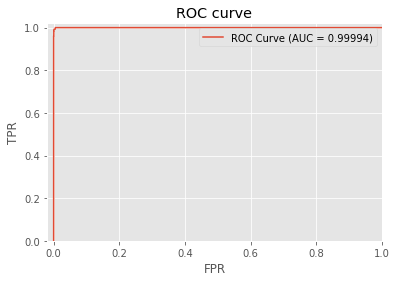

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

**As suggested embedding is better for classification of positive and negative!**

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

**Download the network**

In [0]:
# Change settings here
DATASET = 'enron'
FILENAME = 'enron_mail_20150507.tar.gz'
DOWNLOAD = f'https://www.cs.cmu.edu/~./{DATASET}/{FILENAME}'

In [0]:
# clean main folders
!rm -r *
!ls

# Creating a dataset directory. 
# -p Will also create any intermediate directories that don't exist
!mkdir -p ./datasets/$DATASET/zip
!mkdir -p ./datasets/$DATASET/data
!ls ./datasets/$DATASET

# # download the dataset from SSA and unzip it
!wget $DOWNLOAD -O ./datasets/$DATASET/zip/$FILENAME
!ls ./datasets/$DATASET/zip
# ZIP
# !unzip {"./datasets/$DATASET/zip/$FILENAME"} -d {"./datasets/$DATASET/zip/"}
# tar.gz
!tar -xf ./datasets/$DATASET/zip/$FILENAME -C ./datasets/$DATASET/data
!rm -r ./datasets/$DATASET/zip/
# !tar -z -x -v -f "./datasets/$DATASET/zip/$FILENAME"

data  zip
--2020-05-11 21:01:09--  https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443254787 (423M) [application/x-gzip]
Saving to: ‘./datasets/enron/zip/enron_mail_20150507.tar.gz’

./datasets/enron/zi 100%[===================>] 422.72M  1.73MB/s    in 4m 6s   

2020-05-11 21:05:16 (1.72 MB/s) - ‘./datasets/enron/zip/enron_mail_20150507.tar.gz’ saved [443254787/443254787]

enron_mail_20150507.tar.gz


In [0]:
!ls ./datasets/$DATASET/data

maildir


In [0]:
!ls ./datasets/$DATASET/data/maildir

allen-p      fischer-m	     kitchen-l	      phanis-s	     smith-m
arnold-j     forney-j	     kuykendall-t     pimenov-v      solberg-g
arora-h      fossum-d	     lavorato-j       platter-p      south-s
badeer-r     gang-l	     lay-k	      presto-k	     staab-t
bailey-s     gay-r	     lenhart-m	      quenet-j	     stclair-c
bass-e	     geaccone-t      lewis-a	      quigley-d      steffes-j
baughman-d   germany-c	     linder-e	      rapp-b	     stepenovitch-j
beck-s	     gilbertsmith-d  lokay-m	      reitmeyer-j    stokley-c
benson-r     giron-d	     lokey-t	      richey-c	     storey-g
blair-l      griffith-j      love-p	      ring-a	     sturm-f
brawner-s    grigsby-m	     lucci-p	      ring-r	     swerzbin-m
buy-r	     guzman-m	     maggi-m	      rodrique-r     symes-k
campbell-l   haedicke-m      mann-k	      rogers-b	     taylor-m
carson-m     hain-m	     martin-t	      ruscitti-k     tholt-j
cash-m	     harris-s	     may-l	      sager-e	     thomas-p
causholli-m  hayslett-r      mc

**Create a dataframe of the roles and define whether or not the employee is manager**

In [0]:
import pandas as pd
roles_file = 'http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt'
pd_roles = pd.read_csv(roles_file, sep="	", header=None, error_bad_lines=False)
pd_roles

b'Skipping line 140: expected 2 fields, saw 3\n'


,0,1
0,albert.meyers,Albert Meyers Employee Specialist
1,a..martin,Thomas Martin Vice President
2,andrea.ring,Andrea Ring N/A
3,andrew.lewis,Andrew Lewis Director
4,andy.zipper,Andy Zipper Vice President Enro...
...,...,...
179,vladi.pimenov,Vladi Pimenov N/A
180,v.weldon,Charles Weldon N/A
181,w..delainey,David Delainey CEO Enro...
182,w..pereira,Susan Pereira Employee


In [0]:
name_index = 0
description_index = 1
description_have_to_contains = 'Manag'
pd_roles["manager"] = pd_roles[description_index].apply(lambda emp_role: True if description_have_to_contains in emp_role else False)
pd_roles.head()

,0,1,manager
0,albert.meyers,Albert Meyers Employee Specialist,False
1,a..martin,Thomas Martin Vice President,False
2,andrea.ring,Andrea Ring N/A,False
3,andrew.lewis,Andrew Lewis Director,False
4,andy.zipper,Andy Zipper Vice President Enro...,False


In [0]:
# Note this is a simple example of parsing the Enron dataset. The code may miss some of the links
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm 

enron_data_set_path = f"./datasets/{DATASET}/data/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

Found 99279 files


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
import networkx as nx

g = nx.DiGraph()
g.add_edges_from(links)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 18590
Number of edges: 32392
Average in degree:   1.7424
Average out degree:   1.7424


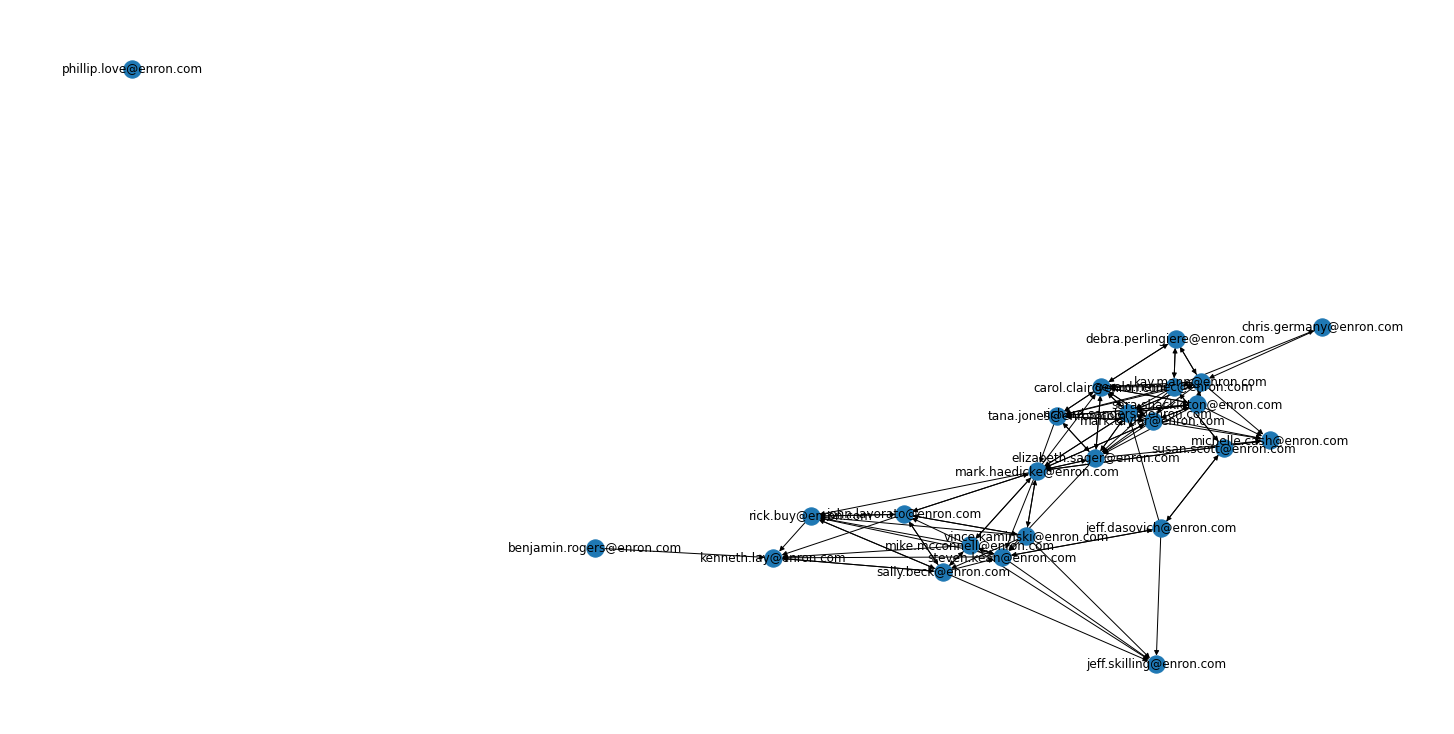

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

min_degree = 200
l = [n for n,degree in dict(g.degree()).items() if degree > min_degree]
h = g.subgraph(l)
plt.figure(figsize=(20,10))
nx.draw_spring(h, with_labels=True)

In [0]:
def is_manager(empl):
  try:
    is_manager = pd_roles.loc[pd_roles[name_index].apply(lambda x: True if x in empl[0] else False), "manager"].values[0]  
    if is_manager:
      return True
    else:
      return False
  except:
    return False  

**Use three different centrality algorithms to identify managers at Enron. Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt).**

**By degree**

In [0]:
import operator
top_k = 10
emp_degree = sorted(dict(g.degree()).items(), key=operator.itemgetter(1), reverse=True)[:top_k]
managers_count = 0
for empl in emp_degree:
  if is_manager(empl):
    managers_count += 1
print(f'{managers_count} managers attained the top-{top_k} highest degree centrality ranks (fraction: {managers_count/top_k})')

1 managers attained the top-10 highest degree centrality ranks (fraction: 0.1)


**By eigenvector centrality**

In [0]:
eigenvector_centrality = sorted(dict(nx.eigenvector_centrality(g)).items(), key=operator.itemgetter(1), reverse=True)
managers_count_eigenvector = 0
for empl in eigenvector_centrality[:top_k]:
    if is_manager(empl):
        managers_count_eigenvector += 1
print(f'{managers_count_eigenvector} managers attained the top-{top_k} highest eigenvector centrality ranks (fraction: {managers_count_eigenvector/top_k})')

2 managers attained the top-10 highest eigenvector centrality ranks (fraction: 0.2)


**By betweenness centrality**

In [0]:
betweenness = sorted(dict(nx.betweenness_centrality(h)).items(), key=operator.itemgetter(1), reverse=True)[:top_k]
managers_count_betweenness = 0
for empl in betweenness:
    if is_manager(empl):
        managers_count_betweenness += 1
print(f'{managers_count_betweenness} managers attained the top-{top_k} highest betweenness centrality ranks (fraction: {managers_count_betweenness/top_k})')

1 managers attained the top-10 highest betweenness centrality ranks (fraction: 0.1)


**Draw the network and visualize one of the centrality measures (10pt).**

I selected to draw the eigenvector centrality algorithm.

In [0]:
draw_top = 50
d = dict(eigenvector_centrality[:draw_top])
l = [name for name, desc in d.items()]
l[:10]

['john.lavorato@enron.com',
 'greg.whalley@enron.com',
 'louise.kitchen@enron.com',
 'sally.beck@enron.com',
 'rick.buy@enron.com',
 'elizabeth.sager@enron.com',
 'tim.belden@enron.com',
 'e..haedicke@enron.com',
 'john.arnold@enron.com',
 'kenneth.lay@enron.com']

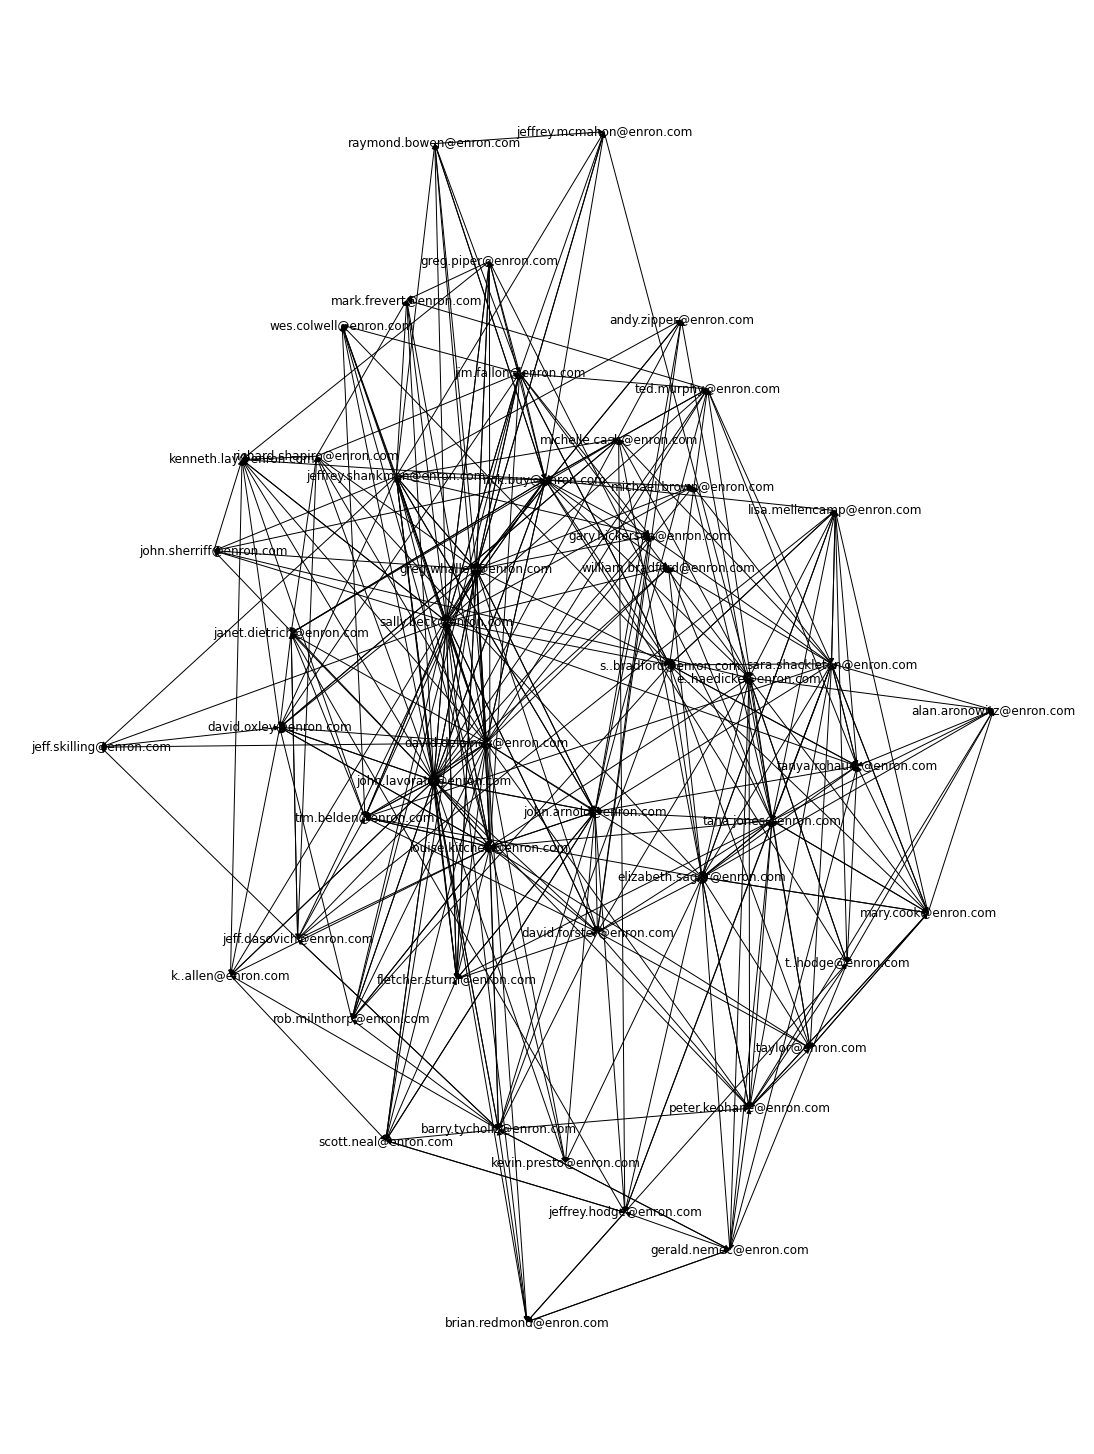

In [0]:
h = g.subgraph(l)
plt.figure(3, figsize=(15,20))
nx.draw_kamada_kawai(h, with_labels=True, node_size=[(d[node]) for node in h.nodes()])